<a href="https://colab.research.google.com/github/wirungu/deep-learning-finance/blob/main/Deep_Learning_in_Financial_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

I recently ran across this [implementation](https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233)  of an LSTM network for stock price prediction, which seemed to me to have some mistakes. (Exercise: What's the main thing wrong with the forecasting?)

I was still curious how effective a crude RNN time series model could be, and particularly whether even the naive benchmark could be beaten given that certain strong forms of the EMH would seem to forbid this: shouldn't today's price be in some sense the best possible indicator for tomorrow's price? Do standard deep learning approaches match or exceed cutting-edge *classical* time series techniques on financial data?
This is my attempt at finding out, and an excuse to learn more about deep learning, time series forecasting and finance.

I've tried to indicate it whenever I actively choose between different possible approaches, and to document anything I'm unsure about in hopes that someone wiser will gently steer me towards a better approach.

# Modules and data preprocessing

## Installation

In [ ]:
!pip install prophet
!pip install --upgrade yfinance
!pip install autokeras

In [ ]:
import autokeras as ak
import prophet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import yfinance as yf

Using TensorFlow backend


Instead of messing with CSVs we'll just use the [Yahoo! Finance API yfinance](https://pypi.org/project/yfinance/) . We'll analyze `MSFT` as a warmup since that's the ticker in the example code there.


In [ ]:
msft = yf.Ticker("MSFT")
# get all stock info
msft.info

{'address1': 'One Microsoft Way',
 'city': 'Redmond',
 'state': 'WA',
 'zip': '98052-6399',
 'country': 'United States',
 'phone': '425 882 8080',
 'fax': '425 706 7329',
 'website': 'https://www.microsoft.com',
 'industry': 'Software—Infrastructure',
 'industryDisp': 'Software—Infrastructure',
 'sector': 'Technology',
 'longBusinessSummary': 'Microsoft Corporation develops, licenses, and supports software, services, devices, and solutions worldwide. The company operates in three segments: Productivity and Business Processes, Intelligent Cloud, and More Personal Computing. The Productivity and Business Processes segment offers Office, Exchange, SharePoint, Microsoft Teams, Office 365 Security and Compliance, Microsoft Viva, and Skype for Business; Skype, Outlook.com, OneDrive, and LinkedIn; and Dynamics 365, a set of cloud-based and on-premises business solutions for organizations and enterprise divisions. The Intelligent Cloud segment licenses SQL, Windows Servers, Visual Studio, Syst

Yahoo! Finance allows me to access 60 days worth of data at a 5 minute granularity, 7 days of 1 minute data and daily data going back over 10 years. For now we're analyzing 60 days of data, but I may need to change this or seek more and better data from elsewhere.

In [ ]:
df = yf.download("MSFT", period= "60d", interval="5m")
# Let's take a look at the data
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-04-19 09:30:00-04:00,285.989990,286.769989,285.600006,286.644989,286.644989,1006171
2023-04-19 09:35:00-04:00,286.619995,286.980011,285.220001,285.290009,285.290009,503674
2023-04-19 09:40:00-04:00,285.279999,285.579987,285.000000,285.450012,285.450012,440315
2023-04-19 09:45:00-04:00,285.450012,286.209991,285.320007,285.940002,285.940002,344039
2023-04-19 09:50:00-04:00,285.899994,286.040009,284.619995,284.625000,284.625000,485759


In [ ]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-07-14 11:45:00-04:00,349.220001,349.459991,349.040009,349.309998,349.309998,123974
2023-07-14 11:50:00-04:00,349.309998,349.540009,349.105011,349.299988,349.299988,80802
2023-07-14 11:55:00-04:00,349.250000,349.450012,349.200012,349.320007,349.320007,108462
2023-07-14 12:00:00-04:00,349.359985,349.359985,348.600006,348.734985,348.734985,231314
2023-07-14 12:05:00-04:00,348.749603,348.825012,348.239990,348.825012,348.825012,192987


Some quick graphs:

<Axes: xlabel='Datetime'>

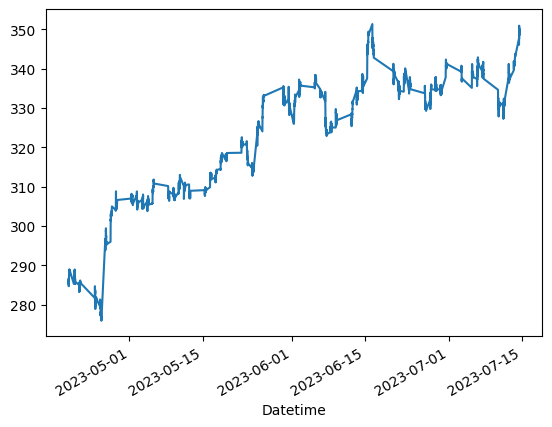

In [ ]:
df['Open'].plot()

<Axes: xlabel='Datetime'>

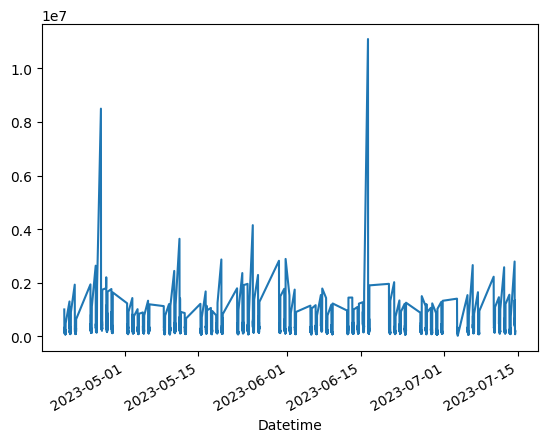

In [ ]:
df['Volume'].plot()

Looks good!

We are going to attempt to forecast opening prices, so let's throw away everything else.

In [ ]:
df2 = df.copy()
df = df['Open']
df.head()

Datetime
2023-04-19 09:30:00-04:00    285.989990
2023-04-19 09:35:00-04:00    286.619995
2023-04-19 09:40:00-04:00    285.279999
2023-04-19 09:45:00-04:00    285.450012
2023-04-19 09:50:00-04:00    285.899994
Name: Open, dtype: float64

## Data splitting

I've gone with a 85-10-5 training-validate-test split. Again, not sure what best practice with such data should be, but hopefully we'll do some testing later.

In [ ]:
n = len(df)

train_df = df[0:int(n*0.85)]
val_df = df[int(n*0.85):int(n*0.95)]
test_df = df[int(n*0.95):]

# See where the tests start
test_df.head()

Datetime
2023-07-11 12:30:00-04:00    330.470001
2023-07-11 12:35:00-04:00    330.429993
2023-07-11 12:40:00-04:00    330.875000
2023-07-11 12:45:00-04:00    330.859985
2023-07-11 12:50:00-04:00    330.890015
Name: Open, dtype: float64

## Normalization

I nearly tore all my hair out on this. There are several available approaches, each with its drawbacks; min-max scaling can't know the minimum or maximum of out-of sample data and that seems particularly ill suited for compounding processes like stock prices. z-score normalization is probably going to work OK, but financial data is famously [heteroskedastic](https://corporatefinanceinstitute.com/resources/data-science/heteroskedasticity/), so you would expect this to fall apart eventually.

I have available Scikit-Learn's `MinMaxScaler, RobustScaler` and `StandardScaler` and `tf.keras.layers.Normalization` and even `tf.keras.utils.normalize`.

I wasn't able to find decisive advice on suitable normalization: the most direct resource I found was the paper [*Impact of Data Normalization on Stock Index Forecasting*](https://www.mirlabs.org/ijcisim/regular_papers_2014/IJCISIM_24.pdf)
by Nayak et al. (and [this](https://arxiv.org/pdf/1812.05519) very similar paper by a different author.)

They essentially suggested a sigmoid normalization $\hat{x} = \frac{1}{1+e^x}.$
Can/should this be done within the model or as part of preprocessing?

I have for now decided to use `StandardScaler`.

I've also not seen any such models use logarithmic returns instead of raw prices, and I do not fully understand why this is the case. Seems to me that's exactly the missing information a machine learning model needs to supply if it's going to be worth anything. Do your log returns predictions beat a random walk?

I think I should normalize each dataset separately, so as not to leak the test data into the training set. It probably wouldn't matter all that much anyway.

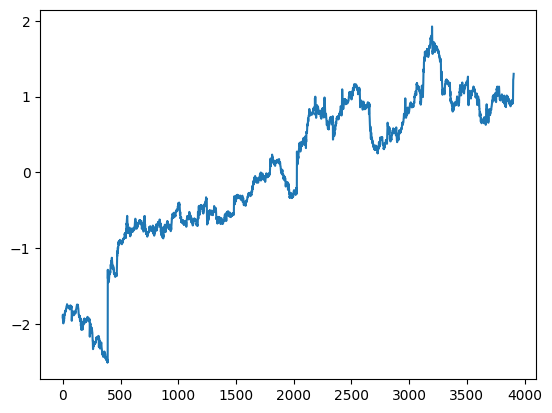

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

training_opens = train_df.values.reshape(-1, 1) # scaler takes 2D vectors
scaled_training_opens = sc.fit_transform(training_opens)
plt.plot(scaled_training_opens)

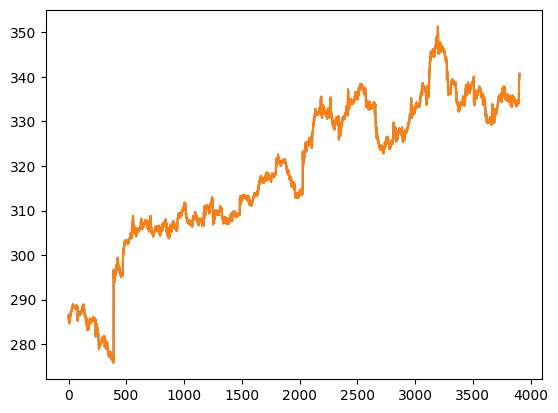

In [ ]:
# Just checking;
inv = sc.inverse_transform(scaled_training_opens)
plt.plot(inv)
plt.plot(training_opens)

Phew! Now we scale the validation and test data:

In [ ]:
val_opens = val_df.values.reshape(-1,1)
scaled_val_opens = sc.transform(val_opens)

test_opens = test_df.values.reshape(-1,1)
scaled_test_opens = sc.transform(test_opens)
scaled_val_opens.shape

(460, 1)

# Modeling



## Data windowing
There's probably a more elegant way to do this, but I
can't think of it/my Google-fu is not strong enough to find it. I'm positive there's a way without descending into NumPy arrays.

I would use `from keras.preprocessing.sequence import TimeseriesGenerator` but apparently it's deprecated, so
🤷

I've also gone with a sliding window rather than an expanding one. Not sure why.

In [ ]:
def windowing(vec, windowsize=60):
  X = []
  y = []

  for i in range(len(vec) - windowsize):
    x = [v for v in vec[i:i+60]]
    X.append(x)
    label = vec[i+60]
    y.append(label)

  return np.array(X), np.array(y)

In [ ]:
X_train,y_train = windowing(scaled_training_opens, 60)
X_val,y_val = windowing(scaled_val_opens, 60)
X_test,y_test = windowing(scaled_test_opens, 60)

## Model training and validation

Let's build a model!

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError



In [ ]:
model1 = Sequential()
model1.add(InputLayer((60,1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
cp = ModelCheckpoint('model1/',save_best_only=True)
model1.compile(loss='mse',
               optimizer=Adam(learning_rate=0.0001),
               metrics = [RootMeanSquaredError()])

In [ ]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100,callbacks=[cp])

Epoch 1/100
121/121 [==============================] - 27s 178ms/step - loss: 0.5637 - root_mean_squared_error: 0.7508 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1035
Epoch 2/100
121/121 [==============================] - 10s 85ms/step - loss: 0.0468 - root_mean_squared_error: 0.2163 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0964
Epoch 3/100
121/121 [==============================] - 7s 58ms/step - loss: 0.0121 - root_mean_squared_error: 0.1098 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0922
Epoch 4/100
121/121 [==============================] - 4s 33ms/step - loss: 0.0095 - root_mean_squared_error: 0.0976 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0981
Epoch 5/100
121/121 [==============================] - 10s 84ms/step - loss: 0.0084 - root_mean_squared_error: 0.0916 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0895
Epoch 6/100
121/121 [==============================] - 7s 61ms/step - loss: 0.0077 - root_mean_squared_error: 0.0877 - val_los

Saving the best model:

In [ ]:
model1 = tf.keras.models.load_model('model1/')


## Testing

In [ ]:
train_predictions = model1.predict(X_train)
train_results = pd.DataFrame(data={'Training Predictions':train_predictions.flatten(), 'Actuals':y_train.flatten()})
train_results

121/121 [==============================] - 2s 11ms/step


,Training Predictions,Actuals
0,-1.781534,-1.784897
1,-1.786682,-1.810787
2,-1.803337,-1.785486
3,-1.799134,-1.772538
4,-1.788542,-1.769006
...,...,...
3841,1.019837,1.229056
3842,1.114673,1.231410
3843,1.175983,1.250832
3844,1.222053,1.296151


In [ ]:
val_predictions = model1.predict(X_val)
val_results = pd.DataFrame(data={'Validation Predictions':val_predictions.flatten(), 'Actuals':y_val.flatten()})
val_results

13/13 [==============================] - 0s 11ms/step


,Validation Predictions,Actuals
0,1.292933,1.299093
1,1.292527,1.282025
2,1.284808,1.295562
3,1.286136,1.316161
4,1.295913,1.303802
...,...,...
395,0.771229,0.807655
396,0.797695,0.747624
397,0.788051,0.725995
398,0.771239,0.708780


Now the moment of truth:

In [ ]:
test_predictions = model1.predict(X_test)
test_results = pd.DataFrame(data={'Test Predictions':test_predictions.flatten(), 'Actuals':y_test.flatten()})
test_results

6/6 [==============================] - 0s 11ms/step


,Test Predictions,Actuals
0,1.292573,1.245535
1,1.268037,1.223759
2,1.243029,1.203454
3,1.218239,1.210811
4,1.206336,1.202572
...,...,...
165,1.809350,1.803479
166,1.802381,1.808776
167,1.800708,1.805244
168,1.798000,1.811718


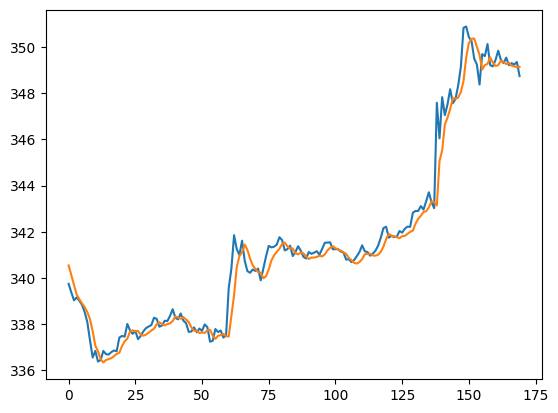

In [ ]:
plt.plot(sc.inverse_transform(y_test))
plt.plot(sc.inverse_transform(test_predictions))

Not bad for a first attempt!

# Prediction and uncertainty
When I get some time I will compare the prediction accuracy among some different models:

  1. Naive Benchmark: Using previous entry as next prediction.  
  2. Quantile Regression Forest
  3. A basic stacked LSTM. I'm going to add a few layers to our model above
  4. A BNN
  5. ARIMA
  6. Prophet

  
  A question: Should the EMH imply that the naive benchmark's error rate is a lower bound for all other models? Which error rate(s)?